# Web Scraping

Last time, we looked at REST API's as a source of data. You can get lots of very high quality data this way.

Some data is available online, but not through an API. When this is the case, some times you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with.

We'll be scraping data about used cars in Charlottesville from Craigslist. This will give us a chance to put those wrangling, EDA, and visualization skills to work.

We'll use the `requests` package, as we did with API's, but will be getting the kinds of web pages you see everyday. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville.

## 1. Pick something else on Craigslist: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of EDA you'd do with it. I look at used cars below.

In [116]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/129.0.0.0 Safari/537.36'}
url = 'https://washingtondc.craigslist.org/search/jwa?purveyor=owner#search=1~gallery~0~23'
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tages, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

## 2. Get your search results of interest and extract data from them, using code similar to what's below.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [117]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

For each listing, we'll use the `.find` method to search within the listing record for specific information. To get the information we want, we can then use `.get_text()`.

In the code below, two more things happen.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [119]:
import re # Regular expressions

types = ['watch', 'watches','earrings','ring','rings','pendant','necklace',
         'necklaces','brooch','jeep','jewelry box', 'bracelet', 'bracelets']
# Added location class to see location data within DC area
data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    location = listings[k].find('div',class_='location').get_text()
    link = listings[k].find(href=True)['href']
    # Get jewelry type from the title string:
    words = title.split()
    hits = [word for word in words if word in types] # Find jewelry type in the title
    if len(hits) == 0:
        type = 'missing'
    else:
        type = hits[0]
    data.append({'title':title,'price':price,'location':location,'link':link,'type':type})

## 3. Wrangle your data, do some EDA, and make some plots. Try to find some interesting relationships or stories to tell about your data.

In [120]:
## Wrangle the data (price and location)
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['location'] = df['location'].str.replace('\n','').str.strip()
print(df.shape)
df.to_csv('craigslist_dc_jewelry.csv')
df.head(15)

(354, 5)


,title,price,location,link,type
0,new: large watch quartz (large numbers) black ...,15,Annandale,https://washingtondc.craigslist.org/nva/jwl/d/...,watch
1,"omega and swatch collaboration ""moonwatch"" col...",350,Ashburn,https://washingtondc.craigslist.org/nva/jwl/d/...,watches
2,men’s fossil twist arkitekt automatic black wr...,100,Manassas,https://washingtondc.craigslist.org/mld/jwl/d/...,watch
3,seiko 7n42-8089 in great cond with new batt ke...,50,"Olney, MD",https://washingtondc.craigslist.org/mld/jwl/d/...,missing
4,citizen 5930-s10981 elegance gold tone; gorgeo...,40,"OLNEY, MD",https://washingtondc.craigslist.org/mld/jwl/d/...,missing
5,vtg seiko women’s 26mm quartz watch 1n00-0a29 ...,40,"Olney, MD",https://washingtondc.craigslist.org/mld/jwl/d/...,watch
6,vtg seiko 3y03-0160 [a4] watch gold tone day d...,25,"OLNEY, MD",https://washingtondc.craigslist.org/mld/jwl/d/...,watch
7,new-bee kind-you are my sunshine necklace,10,Haymarket,https://washingtondc.craigslist.org/nva/jwl/d/...,necklace
8,brand new silver band men’s tourneau watch wit...,300,maryland,https://washingtondc.craigslist.org/mld/jwl/d/...,watch
9,brand new black display face men’s tourneau wa...,300,maryland,https://washingtondc.craigslist.org/mld/jwl/d/...,watch


With the data in and wrangled, we can now do EDA:

## Grayson's EDA

In [121]:
df.dtypes

,0
title,object
price,int64
location,object
link,object
type,object


In [122]:
df['price'].describe()

,price
count,354.00
mean,4255.74
std,65677.87
min,0.00
25%,15.00
50%,50.00
75%,360.00
max,1234567.00


In [123]:
print(df['price'].unique())
print(df['price'].value_counts())

[     15     350     100      50      40      25      10     300   10500
     360       0     500       5    4400      20      75     460     450
     120      35    1000     750     200     250     175       8      45
    8798    5978    1200     150      30       1    9500     420     400
     900       9     550    1600     600    2000 1234567      65      36
     800     125       6       3     140    3000   12500    7250   12850
   16000     849     195      80      49    4900     180      59      60
     325    3795      90   46999    4000    5000   40000     595     895
     295     225       4      95      55     495     395      39    2500
     590]
price
10       43
360      34
20       24
15       21
50       21
         ..
16000     1
849       1
5978      1
8798      1
590       1
Name: count, Length: 82, dtype: int64


In [124]:
df['type'].describe()

,type
count,354
unique,12
top,watch
freq,108


In [125]:
print(df['type'].unique())
print(df['type'].value_counts())

['watch' 'watches' 'missing' 'necklace' 'bracelet' 'pendant' 'ring'
 'earrings' 'bracelets' 'necklaces' 'brooch' 'rings']
type
watch        108
missing      105
necklace      46
ring          22
earrings      22
pendant       21
bracelet      11
watches        6
bracelets      5
brooch         4
necklaces      2
rings          2
Name: count, dtype: int64


In [126]:
print(df['location'].value_counts())
print(df['location'].unique())

location
Silver Spring       42
Gaithersburg        30
Vienna              22
Alexandria          22
Dunkirk             20
                    ..
Lake Ridge, VA       1
Dunn Loring          1
College Park, MD     1
McLean               1
foggy bottom         1
Name: count, Length: 83, dtype: int64
['Annandale' 'Ashburn' 'Manassas' 'Olney, MD' 'OLNEY, MD' 'Haymarket'
 'maryland' 'Gaithersburg' 'Chantilly' 'Silver Spring'
 'Gaithersburg / Shady Grove' 'Cabin John' 'northern virginia'
 'Washington' 'district of columbia' 'Burke' 'Fairfax Station'
 'Foggy Bottom' 'Rockville' 'Alexandria, Mt Vernon'
 "Reston/Tyson's Corner" 'rockville aspen hill' 'Fairfax City' 'Herndon'
 'Mclean' 'Springfield' 'Hyattsville' 'Rockville, MD' 'CULPEPER'
 'Woodbridge, VA' 'University Park, MD' 'Hyattsville, MD' 'OAK HILL'
 'Alexandria' 'Clinton, MD' 'Annandale, Va' 'SILVER SPRING' 'Derwood'
 'Virginia' 'Nokesville, VA' 'Great Falls' 'Vienna' 'GERMANTOWN, MD'
 'Mt Vernon, Woodlawn' 'Fairfax' 'Falls Church' 'La

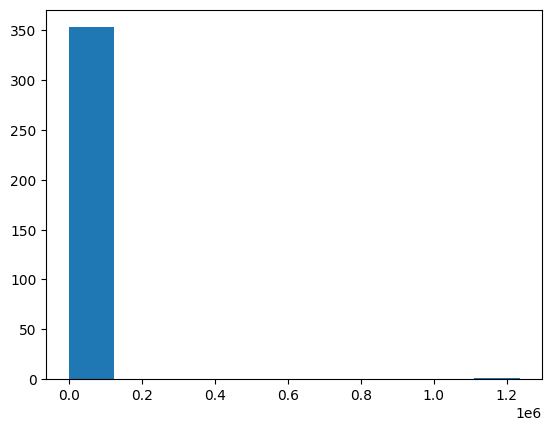

In [127]:
df['price'].hist(grid=False)
plt.show()

# Badly scaled; need to use natural log

<Axes: xlabel='price', ylabel='Density'>

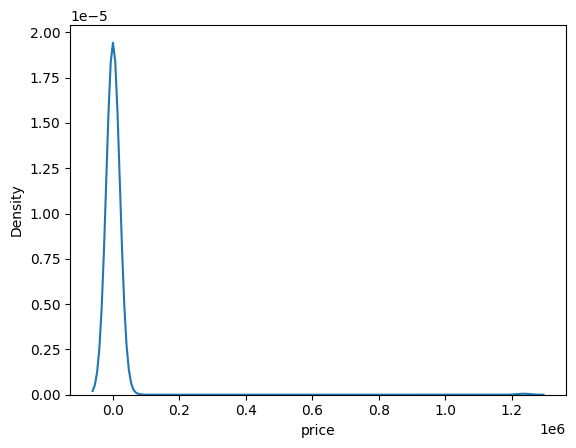

In [128]:
sns.kdeplot(df['price'])

# Again, badly scaled; need to use natural log

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='price_log', ylabel='Density'>

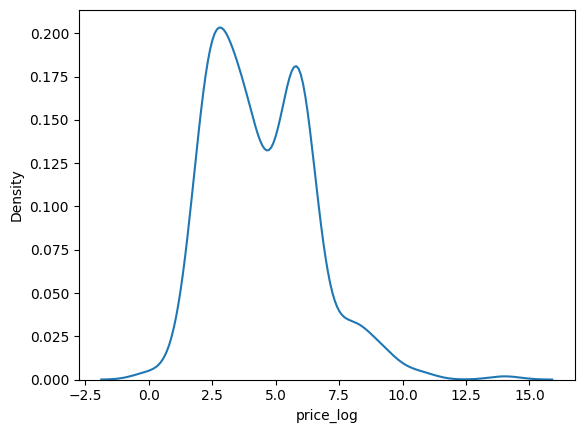

In [129]:
df['price_log'] = np.log(df['price'])
sns.kdeplot(data=df,x='price_log')

<Axes: >

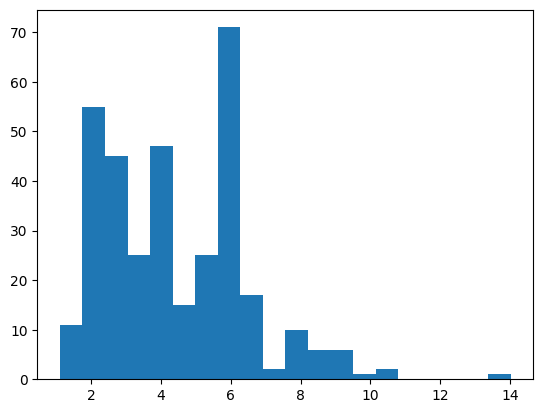

In [130]:
df.loc[df['price_log']>0,'price_log'].hist(bins=20,grid=False)

<Axes: xlabel='type'>

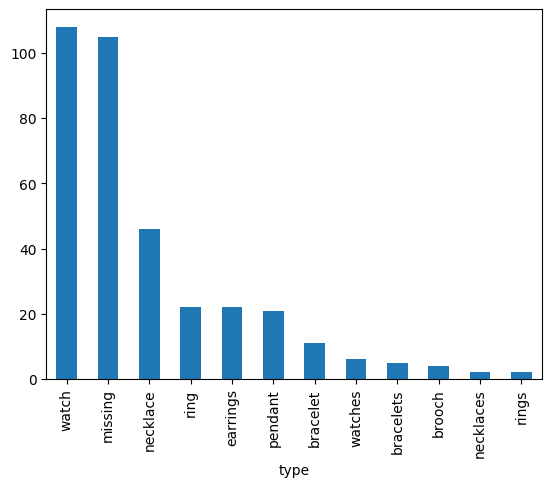

In [131]:
count=df['type'].value_counts()
count.plot(kind='bar')

<Axes: xlabel='price_log', ylabel='type'>

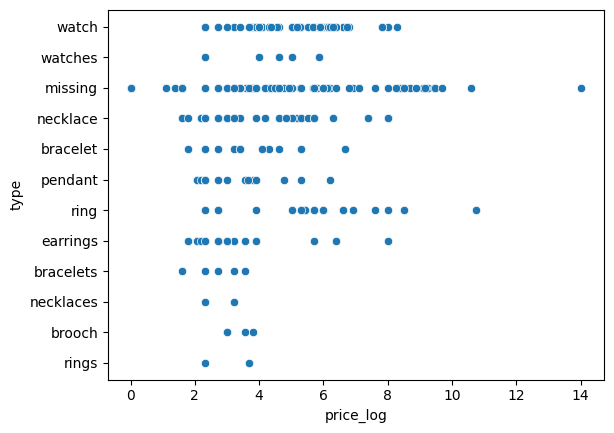

In [133]:
sns.scatterplot(data=df,x='price_log', y='type')

In [134]:
# Price by type:
df.loc[:,['price','type']].groupby('type').describe()

price                                                         
           count     mean       std   min    25%    50%    75%        max
type                                                                     
bracelet   11.00   122.82    231.53  6.00  20.00  30.00  87.50     800.00
bracelets   5.00    18.00     12.04  5.00  10.00  15.00  25.00      35.00
brooch      4.00    30.00     12.25 20.00  20.00  27.50  37.50      45.00
earrings   22.00   190.95    641.98  0.00  10.00  15.00  23.75    3000.00
missing   105.00 13196.03 120435.54  0.00  10.00  30.00 300.00 1234567.00
necklace   46.00   224.22    648.52  0.00  10.00  20.00  91.25    3000.00
necklaces   2.00    17.50     10.61 10.00  13.75  17.50  21.25      25.00
pendant    21.00    54.19    112.19  8.00  10.00  10.00  39.00     500.00
ring       22.00  2832.00   9936.42 10.00 162.50 300.00 750.00   46999.00
rings       2.00    25.00     21.21 10.00  17.50  25.00  32.50      40.00
watch     108.00   376.68    563.95 10.00  71.25 360.00 360.00    4000.00
watches     6.00   110.83    129.94  0.00  21.25  77.50 137.50     350.00

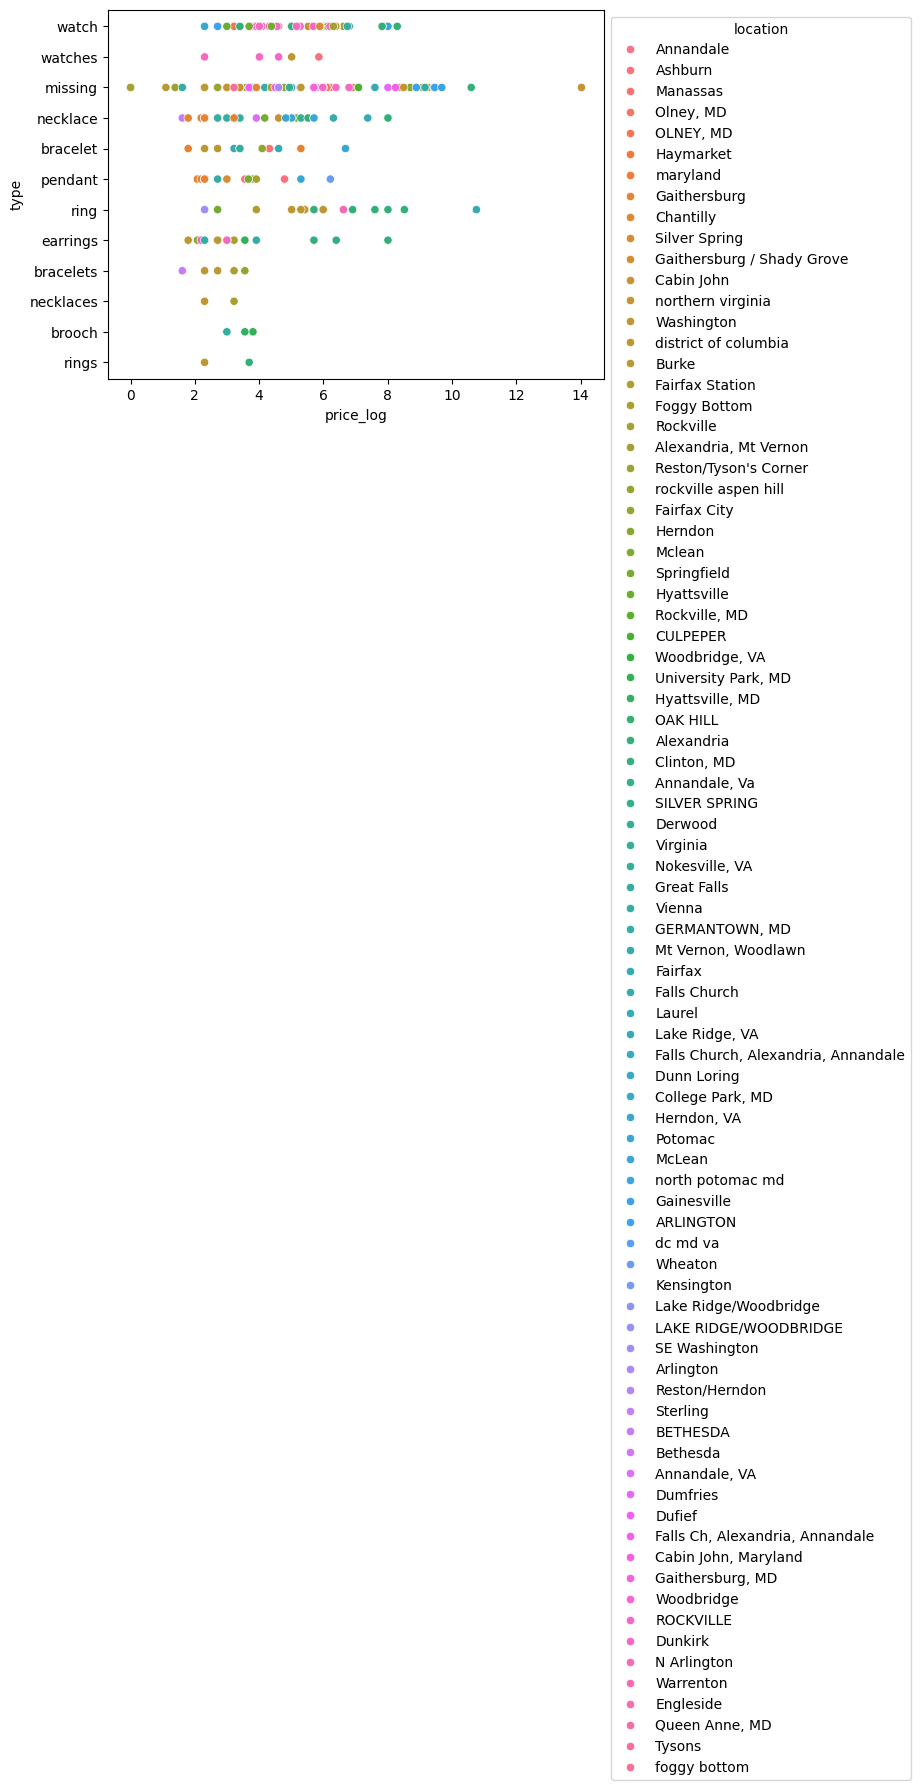

In [135]:
y=sns.scatterplot(data=df,x='price_log', y='type',hue='location')
sns.move_legend(y, "upper left", bbox_to_anchor=(1, 1))